# Testing Notebook - Regression Random Forest

In [1]:
from scripts.regression_random_forest import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor as SklearnRandomForestRegressor
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


RANDOM_STATE = 42

## Helper functions

In [2]:
"""Generate synthetic regression data using scikit-learn's make_regression function."""
def generate_regression_data(n_samples=100, n_features=1, noise=0.1, random_state=RANDOM_STATE):
  X, y = make_regression(n_samples=n_samples, n_features=n_features, noise=noise, random_state=random_state)
  print("Generated regression data with {} samples and {} features.".format(n_samples, n_features))
  print("First 5 samples of X:\n", X[:5])
  print("First 5 samples of y:\n", y[:5])
  return X, y

"""Evaluate a regression model using cross-validation and return performance metrics."""
def evaluate_model(model, X, y, cv=5):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["r2", "neg_mean_squared_error", "neg_mean_absolute_error"],
        return_train_score=False,
    )

    return {
        "r2_mean": np.mean(cv_results["test_r2"]),
        "r2_std":  np.std(cv_results["test_r2"]),
        "mse_mean": -np.mean(cv_results["test_neg_mean_squared_error"]),
        "mae_mean": -np.mean(cv_results["test_neg_mean_absolute_error"]),
    }

## Definition of testing configurations

In [3]:
TESTING_CONFIGS = [
  {
    "description": "Basic regression data with low noise",
    "n_samples": 100,
    "n_features": 1,
    "noise": 0.1
  },
  {
    "description": "Regression data with higher noise",
    "n_samples": 100,
    "n_features": 1,
    "noise": 10.0
  },
  {
    "description": "Regression data with multiple features",
    "n_samples": 200,
    "n_features": 5,
    "noise": 5.0
  },
  {
    "description": "Larger dataset with moderate noise",
    "n_samples": 5000,
    "n_features": 3,
    "noise": 2.0
  },
  {
    "description": "Large dataset with low noise",
    "n_samples": 10000,
    "n_features": 2,
    "noise": 0.5
  },
  {
    "description": "Large dataset with high noise",
    "n_samples": 10000,
    "n_features": 2,
    "noise": 20.0
  },
  {
    "description": "Moderate dataset with many features",
    "n_samples": 1000,
    "n_features": 50,
    "noise": 5.0
  }
]

HYPERPARAM_CONFIGS = [
    {
        "name": "rf_shallow",
        "n_estimators": 100,
        "max_depth": 2,
        "min_samples_leaf": 1,
        "min_samples_split": 2,
        "max_features": "sqrt",
        "bootstrap": True,
    },
    {
        "name": "rf_medium",
        "n_estimators": 100,
        "max_depth": 4,
        "min_samples_leaf": 1,
        "min_samples_split": 2,
        "max_features": "sqrt",
        "bootstrap": True,
    },
    {
        "name": "rf_deep",
        "n_estimators": 100,
        "max_depth": 8,
        "min_samples_leaf": 1,
        "min_samples_split": 2,
        "max_features": "sqrt",
        "bootstrap": True,
    },
    {
        "name": "rf_unrestricted",
        "n_estimators": 100,
        "max_depth": None,
        "min_samples_leaf": 1,
        "min_samples_split": 2,
        "max_features": "sqrt",
        "bootstrap": True,
    },
    {
        "name": "rf_regularized_leaf",
        "n_estimators": 100,
        "max_depth": None,
        "min_samples_leaf": 5,
        "min_samples_split": 2,
        "max_features": "sqrt",
        "bootstrap": True,
    },
    {
        "name": "rf_strongly_regularized",
        "n_estimators": 100,
        "max_depth": None,
        "min_samples_leaf": 10,
        "min_samples_split": 10,
        "max_features": "sqrt",
        "bootstrap": True,
    },
    {
        "name": "rf_bagging_only",
        "n_estimators": 100,
        "max_depth": None,
        "min_samples_leaf": 1,
        "min_samples_split": 2,
        "max_features": None,  
        "bootstrap": True,
  }
]

## Runing the tests

For each configuration we will train the scikit-learn's built-in regression random forest model as well as our implementation, we collect useful statistics and compare them.

In [4]:
results = []

for config in TESTING_CONFIGS:
    print("=" * 80)
    print(f"Dataset: {config['description']}")
    print("=" * 80)

    X, y = generate_regression_data(
        n_samples=config["n_samples"],
        n_features=config["n_features"],
        noise=config["noise"],
    )

    for hp in HYPERPARAM_CONFIGS:
        print("-" * 80)
        print(f"Hyperparams: {hp['name']}")

        model_specs = [
            (
                "our",
                RandomForestRegressor(
                    n_estimators=hp["n_estimators"],
                    max_depth=hp["max_depth"],
                    min_samples_leaf=hp["min_samples_leaf"],
                    min_samples_split=hp["min_samples_split"],
                    max_features=hp["max_features"],
                    bootstrap=hp["bootstrap"],
                    random_state=RANDOM_STATE
                ),
            ),
            (
                "sklearn",
                SklearnRandomForestRegressor(
                    n_estimators=hp["n_estimators"],
                    max_depth=hp["max_depth"],
                    min_samples_leaf=hp["min_samples_leaf"],
                    min_samples_split=hp["min_samples_split"],
                    max_features=hp["max_features"],
                    bootstrap=hp["bootstrap"],
                    random_state=RANDOM_STATE
                ),
            ),
        ]

        for model_name, model in model_specs:
            metrics = evaluate_model(model, X, y)

            print(
                f"{model_name:8s} | "
                f"R²: {metrics['r2_mean']:.3f} ± {metrics['r2_std']:.3f} | "
                f"MSE: {metrics['mse_mean']:.3f} | "
                f"MAE: {metrics['mae_mean']:.3f}"
            )

            results.append({
                "dataset": config["description"],
                "hyperparams": hp["name"],
                "model": model_name,
                **metrics,
            })

Dataset: Basic regression data with low noise
Generated regression data with 100 samples and 1 features.
First 5 samples of X:
 [[ 0.93128012]
 [ 0.08704707]
 [-1.05771093]
 [ 0.31424733]
 [-0.47917424]]
First 5 samples of y:
 [ 38.9917296    3.4964533  -44.05770173  13.09112657 -19.9786311 ]
--------------------------------------------------------------------------------
Hyperparams: rf_shallow
our      | R²: 0.941 ± 0.029 | MSE: 83.496 | MAE: 6.466
sklearn  | R²: 0.941 ± 0.028 | MSE: 82.845 | MAE: 6.230
--------------------------------------------------------------------------------
Hyperparams: rf_medium
our      | R²: 0.990 ± 0.009 | MSE: 15.910 | MAE: 2.156
sklearn  | R²: 0.990 ± 0.009 | MSE: 15.183 | MAE: 2.099
--------------------------------------------------------------------------------
Hyperparams: rf_deep
our      | R²: 0.993 ± 0.009 | MSE: 11.851 | MAE: 1.334
sklearn  | R²: 0.993 ± 0.009 | MSE: 11.250 | MAE: 1.274
-----------------------------------------------------------

## Results

In [5]:
df = pd.DataFrame(results)
paired = (
    df.pivot_table(
        index=["dataset", "hyperparams"],
        columns="model",
        values=["r2_mean", "mse_mean", "mae_mean"]
    )
)

paired.columns = ["_".join(col) for col in paired.columns]
paired = paired.reset_index()

paired["r2_diff"]  = paired["r2_mean_our"]  - paired["r2_mean_sklearn"]
paired["mse_diff"] = paired["mse_mean_our"] - paired["mse_mean_sklearn"]
paired["mae_diff"] = paired["mae_mean_our"] - paired["mae_mean_sklearn"]

paired.head()

,dataset,hyperparams,mae_mean_our,mae_mean_sklearn,mse_mean_our,mse_mean_sklearn,r2_mean_our,r2_mean_sklearn,r2_diff,mse_diff,mae_diff
0,Basic regression data with low noise,rf_bagging_only,1.333733,1.274271,11.849615,11.249964,0.992930,0.993262,-0.000331,0.599651,0.059462
1,Basic regression data with low noise,rf_deep,1.334308,1.274359,11.850647,11.250346,0.992929,0.993261,-0.000332,0.600301,0.059949
2,Basic regression data with low noise,rf_medium,2.156377,2.098668,15.910313,15.182812,0.989953,0.990378,-0.000425,0.727501,0.057709
3,Basic regression data with low noise,rf_regularized_leaf,2.354010,3.943339,25.582914,48.628196,0.984780,0.969691,0.015090,-23.045282,-1.589329
4,Basic regression data with low noise,rf_shallow,6.466155,6.230456,83.495577,82.845285,0.940749,0.940898,-0.000150,0.650291,0.235699


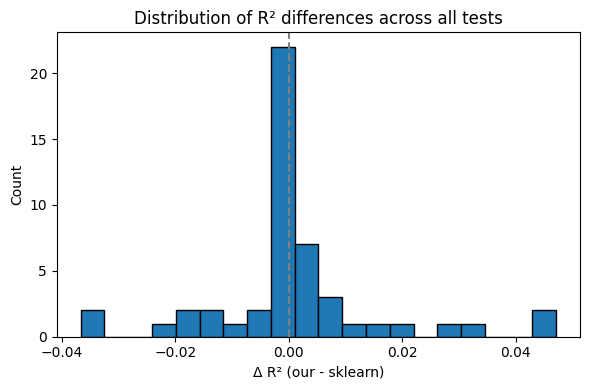

In [6]:
plt.figure(figsize=(6, 4))
plt.hist(paired["r2_diff"], bins=20, edgecolor="black")
plt.axvline(0, linestyle="--", color="gray")
plt.xlabel("Δ R² (our - sklearn)")
plt.ylabel("Count")
plt.title("Distribution of R² differences across all tests")
plt.tight_layout()
plt.show()

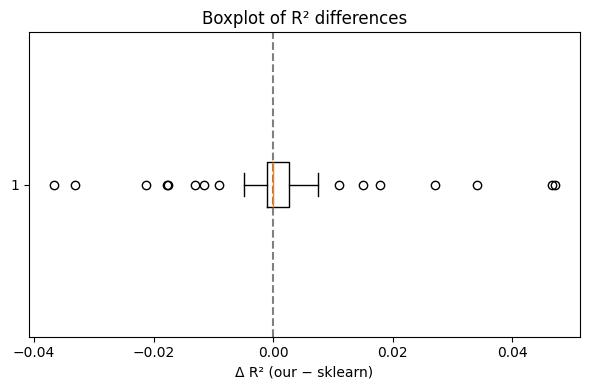

In [ ]:
plt.figure(figsize=(6, 4))
plt.boxplot(
    paired["r2_diff"],
    vert=False,
    showfliers=True
)
plt.axvline(0, linestyle="--", color="gray")
plt.xlabel("Δ R² (our - sklearn)")
plt.title("Boxplot of R² differences")
plt.tight_layout()
plt.show()

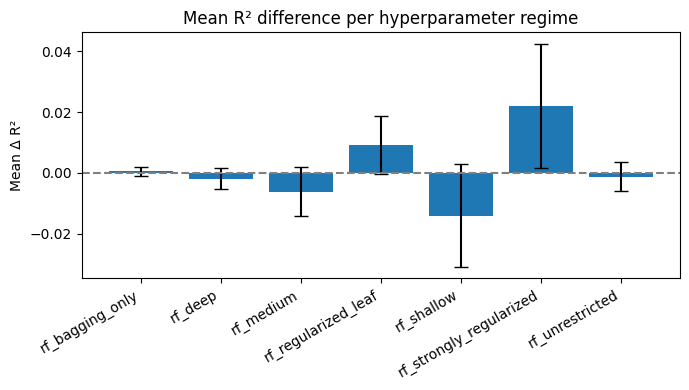

In [8]:
by_hp = (
    paired.groupby("hyperparams")["r2_diff"]
    .agg(["mean", "std"])
    .reset_index()
)

plt.figure(figsize=(7, 4))
plt.bar(
    by_hp["hyperparams"],
    by_hp["mean"],
    yerr=by_hp["std"],
    capsize=5
)
plt.axhline(0, linestyle="--", color="gray")
plt.ylabel("Mean Δ R²")
plt.title("Mean R² difference per hyperparameter regime")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

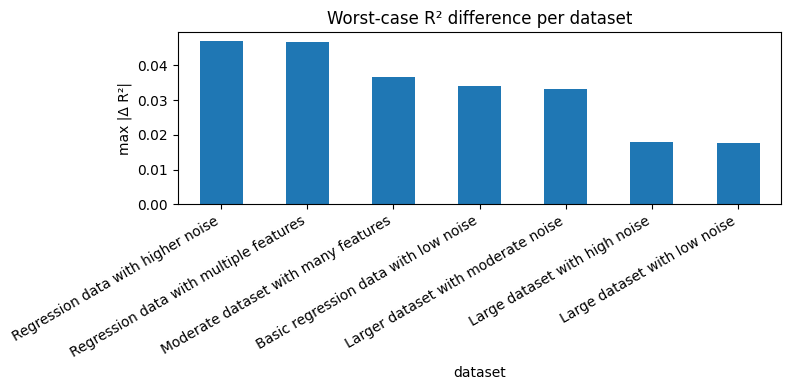

In [9]:
worst_by_dataset = (
    paired.groupby("dataset")["r2_diff"]
    .apply(lambda x: x.abs().max())
    .sort_values(ascending=False)
)

plt.figure(figsize=(8, 4))
worst_by_dataset.plot(kind="bar")
plt.ylabel("max |Δ R²|")
plt.title("Worst-case R² difference per dataset")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

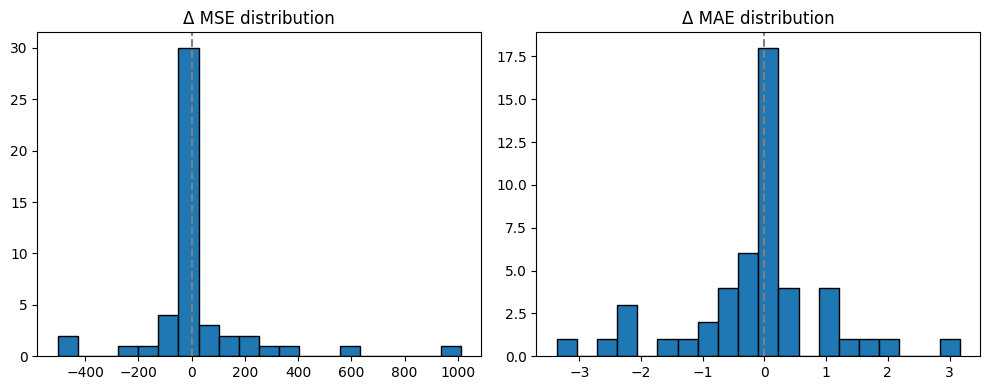

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].hist(paired["mse_diff"], bins=20, edgecolor="black")
axes[0].axvline(0, linestyle="--", color="gray")
axes[0].set_title("Δ MSE distribution")

axes[1].hist(paired["mae_diff"], bins=20, edgecolor="black")
axes[1].axvline(0, linestyle="--", color="gray")
axes[1].set_title("Δ MAE distribution")

plt.tight_layout()
plt.show()